# Equipment Failure Classification - Multi-class Classification

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier, BaggingClassifier
import xgboost
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

## Reading the datasets

In [3]:
errors = pd.read_csv('PdM_errors.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')
maintenance = pd.read_csv('PdM_maint.csv')
telemetry = pd.read_csv('PdM_telemetry.csv')

In [4]:
# Converting the dateime column in all the files to datetime data type.
errors['datetime'] = pd.to_datetime(errors['datetime'])
failures['datetime'] = pd.to_datetime(failures['datetime'])
maintenance['datetime'] = pd.to_datetime(maintenance['datetime'])
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])

In [5]:
# Convert 'machineID' to categorical type
errors['machineID'] = errors['machineID'].astype('category')
failures['machineID'] = failures['machineID'].astype('category')
machines['machineID'] = machines['machineID'].astype('category')
maintenance['machineID'] = maintenance['machineID'].astype('category')
telemetry['machineID'] = telemetry['machineID'].astype('category')

In [6]:
# Merging the telemetry data with the failures data to match the telemetry reading corresponding to the failures
failure_telemetry = telemetry.merge(failures,
                                   on = ('datetime', 'machineID'),
                                   how = 'left')
failure_telemetry.fillna('0', inplace=True) # Fill the no failure with 0

In [7]:
failure_telemetry[['machineID','failure']].value_counts()

machineID  failure
77         0          8761
6          0          8761
57         0          8759
29         0          8759
72         0          8759
                      ... 
73         comp2         1
74         comp1         1
82         comp2         1
85         comp1         1
100        comp2         1
Length: 360, dtype: int64

We want to check how the telemetry data alone can be used to predict the machines' failure. We will do this using different classifiers and compare the accuracy.

In [8]:
# Fit the classifier on the training set
def fit_classifier(clf, X_train, y_train):
    clf = clf.fit(X_train, y_train)
    return clf

In [9]:
def evaluate_classifier(clf, X_test, y_test):
    # Compute the accuracy_score, and roc_auc_score on the test set
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
                                     
    acc_score = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
    
    print(f'Accuracy: {acc_score:.4f}')
    print(f'ROC AUC Score: {auc_score:.4f}')
    
    conf_matrix = confusion_matrix(y_test, y_pred)
        
    # Creating a Seaborn heatmap
    sns.set(font_scale=1.2)  # Adjust font size if needed
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed

    # Annotate each cell with the numeric value using integer formatting
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=True)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

In [10]:
def grid_search_for_classifier(clf, param_grid, X_train, y_train):
    # Grid search
    grid_search = GridSearchCV(clf, param_grid=param_grid)

    # Conduct grid search using the training set
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

    # Set the best paramters for clf
    clf = grid_search.best_estimator_
    
    return clf

### Logistic Regression

As there are 4 types of failures, we will use multiclass logistic regression using 'No failure' as base class. First we split the data into train and test. Since the data has hourly readings of 100 machines from 01/01/2015 06:00 to 01/01/2016 06:00, the data from October to December months for all machines are considered as test set and the remaining data is considered as train set.

In [11]:
failure_telemetry = pd.get_dummies(failure_telemetry, columns = ['machineID'])

In [12]:
# Scaling
readings = ['volt','rotate','pressure', 'vibration']

scaler = StandardScaler()
failure_telemetry[readings] = scaler.fit_transform(failure_telemetry[readings])

In [13]:
# Split data into train and test sets
test_start_date = '2015-10-01 00:00'

train_set = failure_telemetry[failure_telemetry['datetime'] < test_start_date]
test_set = failure_telemetry[failure_telemetry['datetime'] >= test_start_date]

# Display information about the split
print(f'Train set size: {len(train_set)} samples')
print(f'Test set size: {len(test_set)} samples')

Train set size: 654633 samples
Test set size: 221509 samples


In [14]:
# Defining the X and y
X_train = train_set.drop(['failure','datetime'], axis=1)
y_train = train_set['failure']

X_test = test_set.drop(['failure','datetime'], axis=1)
y_test = test_set['failure']

print('\nX_train head:')
print(X_train.head())

print('\nX_Test head:')
print(X_test.head())


X_train head:
       volt    rotate  pressure  vibration  machineID_1  machineID_2  \
0  0.350743 -0.533438  1.105853   0.875609            1            0   
1 -0.509289 -0.832566 -0.488589   0.563960            1            0   
2  0.013662  1.532922 -2.318812  -1.155643            1            0   
3 -0.536137 -1.907042  0.759280   0.137216            1            0   
4 -0.849031 -0.213120  0.998037  -2.680331            1            0   

   machineID_3  machineID_4  machineID_5  machineID_6  ...  machineID_91  \
0            0            0            0            0  ...             0   
1            0            0            0            0  ...             0   
2            0            0            0            0  ...             0   
3            0            0            0            0  ...             0   
4            0            0            0            0  ...             0   

   machineID_92  machineID_93  machineID_94  machineID_95  machineID_96  \
0             0     

In [15]:
# With samples corresponding to the failures being very low, we can clearly see the imbalance in our data
print('Failures in the training set \n', y_train.value_counts())
print('\n')
print('Failures in the test set throughout the data \n', y_test.value_counts())

Failures in the training set 
 0        654052
comp2       187
comp1       153
comp4       138
comp3       103
Name: failure, dtype: int64


Failures in the test set throughout the data 
 0        221329
comp2        72
comp4        41
comp1        39
comp3        28
Name: failure, dtype: int64


Multi-class Logistic Regression
Accuracy: 0.9992
ROC AUC Score: 0.8715


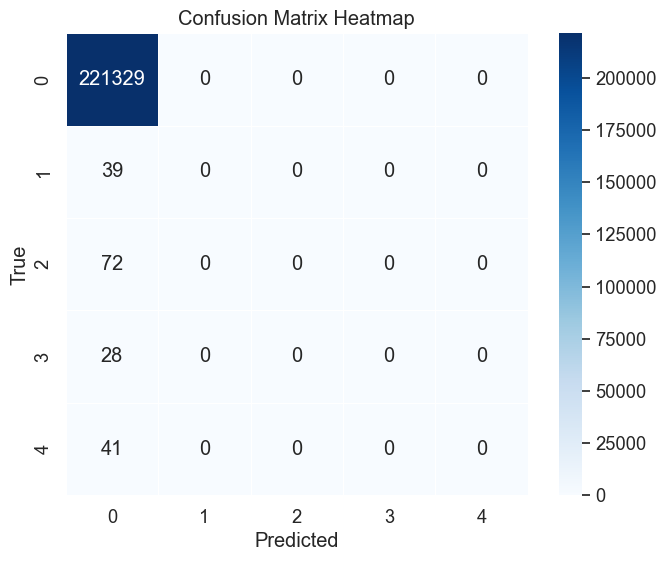

In [16]:
print("Multi-class Logistic Regression")
logreg = LogisticRegression(multi_class = 'ovr')

logreg = fit_classifier(logreg, X_train, y_train)
evaluate_classifier(logreg, X_test, y_test)

Multi-class Logistic Regression
Accuracy: 0.9992
ROC AUC Score: 0.8672


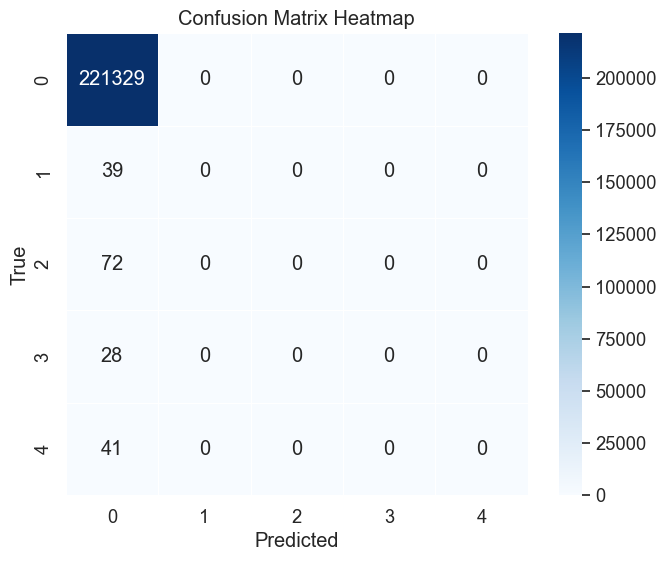

In [17]:
print("Multi-class Logistic Regression")
logreg2 = LogisticRegression(multi_class = 'multinomial')

logreg2 = fit_classifier(logreg2, X_train, y_train)
evaluate_classifier(logreg2, X_test, y_test)

### Decision Tree Classifier

Decision Tree
Accuracy: 0.9983
ROC AUC Score: 0.4999


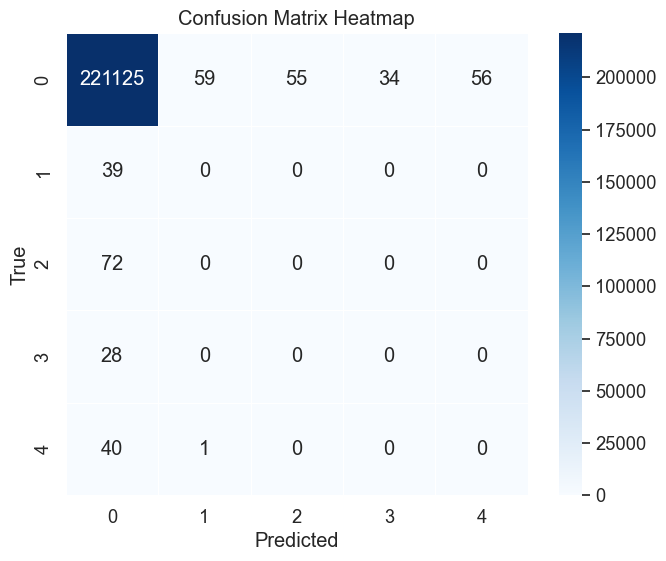

In [18]:
print("Decision Tree")
dt_clf = DecisionTreeClassifier(random_state = 14)

dt_clf = fit_classifier(dt_clf, X_train, y_train)
evaluate_classifier(dt_clf, X_test, y_test)

### Bagging Classifier

Bagging of Decesion Trees
Accuracy: 0.9992
ROC AUC Score: 0.5192


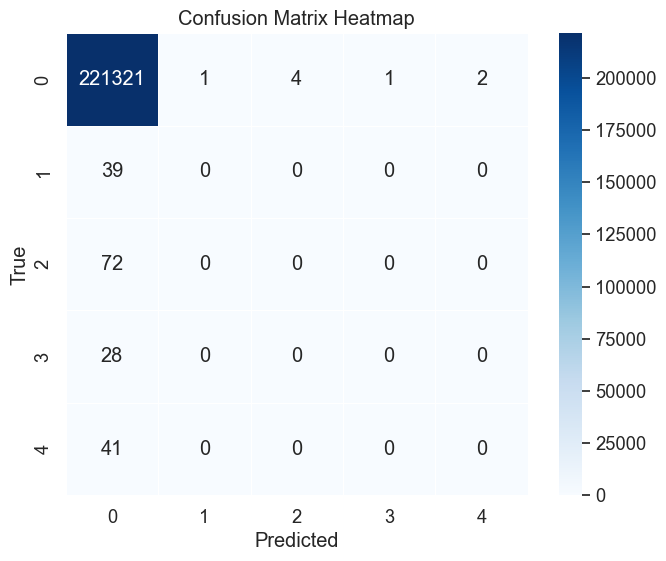

In [19]:
print("Bagging of Decesion Trees")
bag_clf = BaggingClassifier(dt_clf, n_estimators=25, random_state=14)

bag_clf = fit_classifier(bag_clf, X_train, y_train)
evaluate_classifier(bag_clf, X_test, y_test)

# Equipment Failure Classification - Binary Classification

In [20]:
# Merging the telemetry data with the failures data to match the telemetry reading corresponding to the failures
failure_telemetry = telemetry.merge(failures,
                                   on = ('datetime', 'machineID'),
                                   how = 'left')
failure_telemetry.fillna('0', inplace=True) # Fill the no failure with 0
failure_telemetry['failure'] = failure_telemetry['failure'].replace(['comp1', 'comp2', 'comp3', 'comp4'], [1, 1, 1, 1])
failure_telemetry[['machineID','failure']].value_counts()

machineID  failure
77         0          8761
6          0          8761
72         0          8759
57         0          8759
29         0          8759
                      ... 
100        1             3
29         1             2
46         1             2
57         1             2
72         1             2
Length: 198, dtype: int64

In [21]:
failure_telemetry = pd.get_dummies(failure_telemetry, columns = ['machineID'])

In [22]:
# Scaling
readings = ['volt','rotate','pressure', 'vibration']

scaler = StandardScaler()
failure_telemetry[readings] = scaler.fit_transform(failure_telemetry[readings])

In [23]:
# Split data into train and test sets
test_start_date = '2015-10-01 00:00'

train_set = failure_telemetry[failure_telemetry['datetime'] < test_start_date]
test_set = failure_telemetry[failure_telemetry['datetime'] >= test_start_date]

# Display information about the split
print(f'Train set size: {len(train_set)} samples')
print(f'Test set size: {len(test_set)} samples')

Train set size: 654633 samples
Test set size: 221509 samples


In [24]:
# Defining the X and y
X_train = train_set.drop(['failure','datetime'], axis=1)
y_train = train_set['failure']
y_train = y_train.astype(int)

X_test = test_set.drop(['failure','datetime'], axis=1)
y_test = test_set['failure']
y_test = y_test.astype(int)

print('\nX_train head:')
print(X_train.head())

print('\nX_Test head:')
print(X_test.head())


X_train head:
       volt    rotate  pressure  vibration  machineID_1  machineID_2  \
0  0.350743 -0.533438  1.105853   0.875609            1            0   
1 -0.509289 -0.832566 -0.488589   0.563960            1            0   
2  0.013662  1.532922 -2.318812  -1.155643            1            0   
3 -0.536137 -1.907042  0.759280   0.137216            1            0   
4 -0.849031 -0.213120  0.998037  -2.680331            1            0   

   machineID_3  machineID_4  machineID_5  machineID_6  ...  machineID_91  \
0            0            0            0            0  ...             0   
1            0            0            0            0  ...             0   
2            0            0            0            0  ...             0   
3            0            0            0            0  ...             0   
4            0            0            0            0  ...             0   

   machineID_92  machineID_93  machineID_94  machineID_95  machineID_96  \
0             0     

In [25]:
print('Failures in the training set \n', y_train.value_counts())
print('\n')
print('Failures in the test set \n', y_test.value_counts())

Failures in the training set 
 0    654052
1       581
Name: failure, dtype: int64


Failures in the test set 
 0    221329
1       180
Name: failure, dtype: int64


### Logistic Regression - Binary Classification

Binary Classification using Logistic Regression
Accuracy: 0.9992
ROC AUC Score: 0.7244


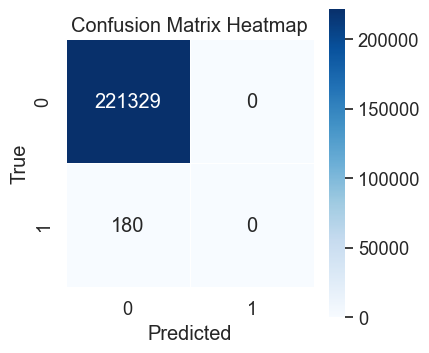

In [29]:
print("Binary Classification using Logistic Regression")
logreg = LogisticRegression()

logreg = fit_classifier(logreg, X_train, y_train)

# Compute the accuracy_score, and roc_auc_score on the test set
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:,1]
    
threshold = 0.5
y_pred_adjusted = (y_pred_proba > threshold).astype(int)
                                     
acc_score = accuracy_score(y_test, y_pred_adjusted)
auc_score = roc_auc_score(y_test, y_pred_proba)
    
print(f'Accuracy: {acc_score:.4f}')
print(f'ROC AUC Score: {auc_score:.4f}')
    
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
        
# Creating a Seaborn heatmap
sns.set(font_scale=1.2)  # Adjust font size if needed
plt.figure(figsize=(4, 4))  # Adjust figure size if needed

# Annotate each cell with the numeric value using integer formatting
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Anamoly Detection - Treating Errors and Failures as Anamolies

In [31]:
machine_telemetry = telemetry.merge(machines,
                                   on = 'machineID')
machine_telemetry

,datetime,machineID,volt,rotate,pressure,vibration,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18
...,...,...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,model4,5
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,model4,5
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,model4,5
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,model4,5


In [32]:
# Convert 'machineID' to categorical type
errors['machineID'] = errors['machineID'].astype('category')
failures['machineID'] = failures['machineID'].astype('category')
machines['machineID'] = machines['machineID'].astype('category')
maintenance['machineID'] = maintenance['machineID'].astype('category')
telemetry['machineID'] = telemetry['machineID'].astype('category')
machine_telemetry['machineID'] = machine_telemetry['machineID'].astype('category')

In [33]:
# Merging the telemetry data with the failures data to match the telemetry reading corresponding to the failures
failure_telemetry = machine_telemetry.merge(failures,
                                   on = ('datetime', 'machineID'),
                                   how = 'left')
failure_telemetry.fillna(0, inplace=True) # Fill the no failure with 0

error_fail_tele = failure_telemetry.merge(errors,
                                         on = ('datetime', 'machineID'),
                                         how = 'left')
error_fail_tele.fillna(0, inplace=True) # Fill the no error with 0

error_fail_tele['anamoly'] = np.where((error_fail_tele['failure'] == 0) & (error_fail_tele['errorID'] == 0), 0, 1)
error_fail_tele[['machineID','anamoly']].value_counts()

machineID  anamoly
77         0          8739
6          0          8738
2          0          8734
86         0          8732
31         0          8732
                      ... 
2          1            32
86         1            31
46         1            31
6          1            23
77         1            22
Length: 200, dtype: int64

In [34]:
error_fail_tele = pd.get_dummies(error_fail_tele, columns = ['machineID', 'model'])

In [35]:
# Scaling
readings = ['volt','rotate','pressure', 'vibration']

scaler = StandardScaler()
error_fail_tele[readings] = scaler.fit_transform(error_fail_tele[readings])

In [36]:
# Split data into train and test sets
test_start_date = '2015-10-01 00:00'

train_set = error_fail_tele[error_fail_tele['datetime'] < test_start_date]
test_set = error_fail_tele[error_fail_tele['datetime'] >= test_start_date]

# Display information about the split
print(f'Train set size: {len(train_set)} samples')
print(f'Test set size: {len(test_set)} samples')

Train set size: 654856 samples
Test set size: 221589 samples


In [39]:
# Defining the X and y
X_train = train_set.drop(['anamoly', 'errorID', 'failure', 'datetime'], axis=1)
y_train = train_set['anamoly']
y_train = y_train.astype(int)

X_test = test_set.drop(['anamoly', 'errorID', 'failure', 'datetime'], axis=1)
y_test = test_set['anamoly']
y_test = y_test.astype(int)

print('\nX_train head:')
print(X_train.head())

print('\nX_Test head:')
print(X_test.head())


X_train head:
       volt    rotate  pressure  vibration  age  machineID_1  machineID_2  \
0  0.350679 -0.532812  1.105749   0.875446   18            1            0   
1 -0.509342 -0.831845 -0.488594   0.563834   18            1            0   
2  0.013602  1.532895 -2.318704  -1.155560   18            1            0   
3 -0.536190 -1.905981  0.759198   0.137142   18            1            0   
4 -0.849079 -0.212595  0.997940  -2.680064   18            1            0   

   machineID_3  machineID_4  machineID_5  ...  machineID_95  machineID_96  \
0            0            0            0  ...             0             0   
1            0            0            0  ...             0             0   
2            0            0            0  ...             0             0   
3            0            0            0  ...             0             0   
4            0            0            0  ...             0             0   

   machineID_97  machineID_98  machineID_99  machineID_100 

In [40]:
print('Anamolies in the training set \n', y_train.value_counts())
print('\n')
print('Anamolies in the test set throughout the data \n', y_test.value_counts())

Anamolies in the training set 
 0    651353
1      3503
Name: anamoly, dtype: int64


Anamolies in the test set throughout the data 
 0    220415
1      1174
Name: anamoly, dtype: int64


### Logistic Regression

Binary Classification using Logistic Regression
Accuracy: 0.9947
ROC AUC Score: 0.5866


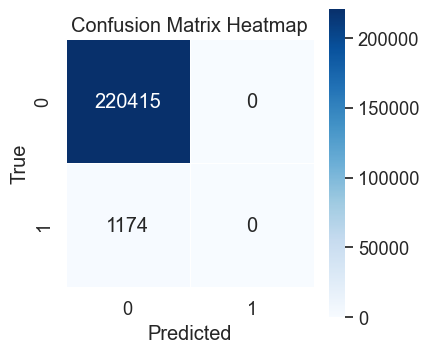

In [41]:
print("Binary Classification using Logistic Regression")
logreg = LogisticRegression()

logreg = fit_classifier(logreg, X_train, y_train)

# Compute the accuracy_score, and roc_auc_score on the test set
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:,1]
    
threshold = 0.5
y_pred_adjusted = (y_pred_proba > threshold).astype(int)
                                     
acc_score = accuracy_score(y_test, y_pred_adjusted)
auc_score = roc_auc_score(y_test, y_pred_proba)
    
print(f'Accuracy: {acc_score:.4f}')
print(f'ROC AUC Score: {auc_score:.4f}')
    
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
        
# Creating a Seaborn heatmap
sns.set(font_scale=1.2)  # Adjust font size if needed
plt.figure(figsize=(4, 4))  # Adjust figure size if needed

# Annotate each cell with the numeric value using integer formatting
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

Due to the class imbalance in the data, the model is not able to detect the failures or anamolies accurately. Let us try to reduce the imbalance by considering the 24 hour average readings as daily data. Since, there is only one failure on any particular day, the average readings for that particular day will be different from the normal day readings. Let us try this and see whether the model will be able to detect the failures or not.

# Binary Classification using daily data

In [42]:
errors['month'] = errors['datetime'].dt.month
errors['day'] = errors['datetime'].dt.day
errors['hour'] = errors['datetime'].dt.hour
errors = errors[['datetime', 'month', 'day', 'hour', 'machineID', 'errorID']]
errors.head()

,datetime,month,day,hour,machineID,errorID
0,2015-01-03 07:00:00,1,3,7,1,error1
1,2015-01-03 20:00:00,1,3,20,1,error3
2,2015-01-04 06:00:00,1,4,6,1,error5
3,2015-01-10 15:00:00,1,10,15,1,error4
4,2015-01-22 10:00:00,1,22,10,1,error4


In [43]:
failures['month'] = failures['datetime'].dt.month
failures['day'] = failures['datetime'].dt.day
failures['hour'] = failures['datetime'].dt.hour
failures = failures[['datetime', 'month', 'day', 'hour', 'machineID', 'failure']]
failures.head()

,datetime,month,day,hour,machineID,failure
0,2015-01-05 06:00:00,1,5,6,1,comp4
1,2015-03-06 06:00:00,3,6,6,1,comp1
2,2015-04-20 06:00:00,4,20,6,1,comp2
3,2015-06-19 06:00:00,6,19,6,1,comp4
4,2015-09-02 06:00:00,9,2,6,1,comp4


In [44]:
telemetry['month'] = telemetry['datetime'].dt.month
telemetry['day'] = telemetry['datetime'].dt.day
telemetry['hour'] = telemetry['datetime'].dt.hour
telemetry = telemetry[['datetime', 'month', 'day', 'hour', 'machineID', 'volt', 'rotate', 'pressure', 'vibration']]
telemetry.head()

,datetime,month,day,hour,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,1,6,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,1,7,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,1,8,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,1,9,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,1,10,1,157.610021,435.376873,111.886648,25.990511


In [45]:
telemetry_24 = telemetry.groupby(['machineID', 'month', 'day']).mean().drop('hour', axis=1)
telemetry_24.reset_index(inplace=True)

In [46]:
machine_telemetry = telemetry_24.merge(machines,
                                   on = 'machineID',
                                      how = 'outer')
machine_telemetry

,machineID,month,day,volt,rotate,pressure,vibration,model,age
0,1,1,1,168.995660,435.494337,97.585197,40.569369,model3,18
1,1,1,2,169.795758,446.832666,98.454608,39.271645,model3,18
2,1,1,3,171.862244,459.204742,97.998233,48.074091,model3,18
3,1,1,4,174.792428,448.743201,101.452266,52.190268,model3,18
4,1,1,5,171.018408,454.822750,102.363114,43.330311,model3,18
...,...,...,...,...,...,...,...,...,...
37195,100,12,27,170.382439,445.068708,100.521423,40.662121,model4,5
37196,100,12,28,170.982029,454.875385,97.864404,39.221774,model4,5
37197,100,12,29,167.114444,459.097599,97.531682,40.117173,model4,5
37198,100,12,30,168.613777,455.140822,98.415400,39.995452,model4,5


In [47]:
# Convert 'machineID' to categorical type
errors['machineID'] = errors['machineID'].astype('category')
failures['machineID'] = failures['machineID'].astype('category')
machines['machineID'] = machines['machineID'].astype('category')
maintenance['machineID'] = maintenance['machineID'].astype('category')
telemetry['machineID'] = telemetry['machineID'].astype('category')
machine_telemetry['machineID'] = machine_telemetry['machineID'].astype('category')

In [48]:
# Merging the telemetry data with the failures data to match the telemetry reading corresponding to the failures
failure_telemetry = machine_telemetry.merge(failures,
                                   on = ('month', 'day', 'machineID'),
                                   how = 'left')
failure_telemetry.fillna(0, inplace=True) # Fill the no failure with 0

error_fail_tele = failure_telemetry.merge(errors,
                                         on = ('month', 'day', 'machineID'),
                                         how = 'left')
error_fail_tele.fillna(0, inplace=True) # Fill the no error with 0

error_fail_tele['failure'] = error_fail_tele['failure'].replace(['comp1', 'comp2', 'comp3', 'comp4'], [1, 1, 1, 1])
error_fail_tele[['machineID','failure']].value_counts()

machineID  failure
81         0          376
72         0          374
61         0          374
74         0          373
44         0          373
                     ... 
34         1            3
100        1            3
57         1            2
29         1            2
72         1            2
Length: 198, dtype: int64

In [49]:
error_fail_tele = error_fail_tele.drop(['datetime_x', 'hour_x', 'datetime_y', 'hour_y'], axis=1)
error_fail_tele

,machineID,month,day,volt,rotate,pressure,vibration,model,age,failure,errorID
0,1,1,1,168.995660,435.494337,97.585197,40.569369,model3,18,0,0
1,1,1,2,169.795758,446.832666,98.454608,39.271645,model3,18,0,0
2,1,1,3,171.862244,459.204742,97.998233,48.074091,model3,18,0,error1
3,1,1,3,171.862244,459.204742,97.998233,48.074091,model3,18,0,error3
4,1,1,4,174.792428,448.743201,101.452266,52.190268,model3,18,0,error5
...,...,...,...,...,...,...,...,...,...,...,...
37716,100,12,27,170.382439,445.068708,100.521423,40.662121,model4,5,0,0
37717,100,12,28,170.982029,454.875385,97.864404,39.221774,model4,5,0,0
37718,100,12,29,167.114444,459.097599,97.531682,40.117173,model4,5,0,0
37719,100,12,30,168.613777,455.140822,98.415400,39.995452,model4,5,0,0


In [50]:
error_fail_tele = pd.get_dummies(error_fail_tele, columns = ['machineID', 'model', 'errorID'])

In [51]:
# Scaling
readings = ['volt','rotate','pressure', 'vibration']

scaler = StandardScaler()
error_fail_tele[readings] = scaler.fit_transform(error_fail_tele[readings])

In [52]:
# Split data into train and test sets
test_start_month = 10

train_set = error_fail_tele[error_fail_tele['month'] < test_start_month]
test_set = error_fail_tele[error_fail_tele['month'] >= test_start_month]

# Display information about the split
print(f'Train set size: {len(train_set)} samples')
print(f'Test set size: {len(test_set)} samples')

Train set size: 28277 samples
Test set size: 9444 samples


In [53]:
# Defining the X and y
X_train = train_set.drop(['failure', 'month', 'day'], axis=1)
y_train = train_set['failure']
y_train = y_train.astype(int)

X_test = test_set.drop(['failure', 'month', 'day'], axis=1)
y_test = test_set['failure']
y_test = y_test.astype(int)

print('\nX_train head:')
print(X_train.head())

print('\nX_Test head:')
print(X_test.head())


X_train head:
       volt    rotate  pressure  vibration  age  machineID_1  machineID_2  \
0  0.057907 -0.034437 -0.098771   0.157409   18            1            0   
1  0.091910  0.145122 -0.038450  -0.065114   18            1            0   
2  0.179733  0.341052 -0.070114   1.444260   18            1            0   
3  0.179733  0.341052 -0.070114   1.444260   18            1            0   
4  0.304262  0.175378  0.169535   2.150070   18            1            0   

   machineID_3  machineID_4  machineID_5  ...  model_model1  model_model2  \
0            0            0            0  ...             0             0   
1            0            0            0  ...             0             0   
2            0            0            0  ...             0             0   
3            0            0            0  ...             0             0   
4            0            0            0  ...             0             0   

   model_model3  model_model4  errorID_0  errorID_error1  e

In [54]:
print('Failures in the training set \n', y_train.value_counts())
print('\n')
print('Failures in the test set throughout the data \n', y_test.value_counts())

Failures in the training set 
 0    27692
1      585
Name: failure, dtype: int64


Failures in the test set throughout the data 
 0    9262
1     182
Name: failure, dtype: int64


### Logistic Regression

Binary Classification using Logistic Regression
Accuracy: 0.9807
ROC AUC Score: 0.7014


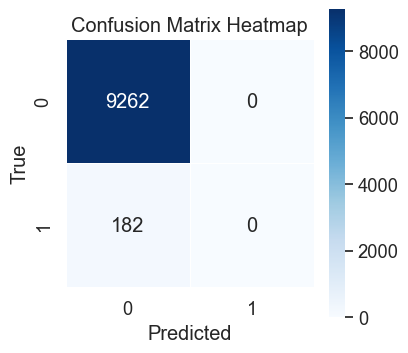

In [55]:
print("Binary Classification using Logistic Regression")
logreg = LogisticRegression()

logreg = fit_classifier(logreg, X_train, y_train)

# Compute the accuracy_score, and roc_auc_score on the test set
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:,1]
    
threshold = 0.5
y_pred_adjusted = (y_pred_proba > threshold).astype(int)
                                     
acc_score = accuracy_score(y_test, y_pred_adjusted)
auc_score = roc_auc_score(y_test, y_pred_proba)
    
print(f'Accuracy: {acc_score:.4f}')
print(f'ROC AUC Score: {auc_score:.4f}')
    
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
        
# Creating a Seaborn heatmap
sns.set(font_scale=1.2)  # Adjust font size if needed
plt.figure(figsize=(4, 4))  # Adjust figure size if needed

# Annotate each cell with the numeric value using integer formatting
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

### Decision Tree Classifier

Decision Tree
Accuracy: 0.9682
ROC AUC Score: 0.5852


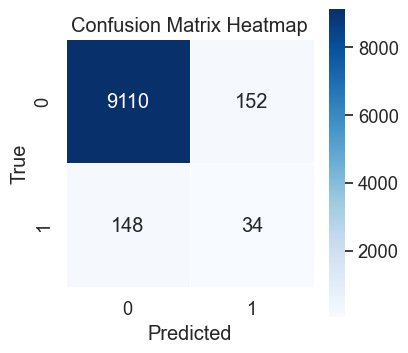

In [56]:
print("Decision Tree")
dt_clf = DecisionTreeClassifier(random_state = 14)

dt_clf = fit_classifier(dt_clf, X_train, y_train)

# Compute the accuracy_score, and roc_auc_score on the test set
y_pred = dt_clf.predict(X_test)
y_pred_proba = dt_clf.predict_proba(X_test)[:,1]
    
threshold = 0.5
y_pred_adjusted = (y_pred_proba > threshold).astype(int)
                                     
acc_score = accuracy_score(y_test, y_pred_adjusted)
auc_score = roc_auc_score(y_test, y_pred_proba)
    
print(f'Accuracy: {acc_score:.4f}')
print(f'ROC AUC Score: {auc_score:.4f}')
    
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
        
# Creating a Seaborn heatmap
sns.set(font_scale=1.2)  # Adjust font size if needed
plt.figure(figsize=(4, 4))  # Adjust figure size if needed

# Annotate each cell with the numeric value using integer formatting
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Using over sampling the negative class to overcome class imbalance 

In [57]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks

In [58]:
errors = pd.read_csv('PdM_errors.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')
maintenance = pd.read_csv('PdM_maint.csv')
telemetry = pd.read_csv('PdM_telemetry.csv')

In [59]:
# Converting the dateime column in all the files to datetime data type.
errors['datetime'] = pd.to_datetime(errors['datetime'])
failures['datetime'] = pd.to_datetime(failures['datetime'])
maintenance['datetime'] = pd.to_datetime(maintenance['datetime'])
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])

In [60]:
errors['errorID'] = errors['errorID'].astype('category')
maintenance['comp'] = maintenance['comp'].astype('category')
machines['model'] = machines['model'].astype('category')
failures['failure'] = failures['failure'].astype('category')

In [61]:
machine_telemetry = telemetry.merge(machines,
                                   on = 'machineID')
machine_telemetry

,datetime,machineID,volt,rotate,pressure,vibration,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18
...,...,...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,model4,5
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,model4,5
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,model4,5
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,model4,5


In [62]:
# Convert 'machineID' to categorical type
errors['machineID'] = errors['machineID'].astype('category')
failures['machineID'] = failures['machineID'].astype('category')
machines['machineID'] = machines['machineID'].astype('category')
maintenance['machineID'] = maintenance['machineID'].astype('category')
telemetry['machineID'] = telemetry['machineID'].astype('category')
machine_telemetry['machineID'] = machine_telemetry['machineID'].astype('category')

In [63]:
# Merging the telemetry data with the failures data to match the telemetry reading corresponding to the failures
error_telemetry = machine_telemetry.merge(errors,
                                   on = ('datetime', 'machineID'),
                                   how = 'left')
error_telemetry['errorID'] = error_telemetry['errorID'].cat.add_categories('none')
error_telemetry.fillna('none', inplace=True) # Fill the no failure with 'none'

error_fail_tele = error_telemetry.merge(failures,
                                         on = ('datetime', 'machineID'),
                                         how = 'left')
error_fail_tele['failure'] = error_fail_tele['failure'].cat.add_categories('none')
error_fail_tele.fillna('none', inplace=True) # Fill the no error with 'none'

error_fail_tele

,datetime,machineID,volt,rotate,pressure,vibration,model,age,errorID,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,none,none
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,none,none
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18,none,none
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18,none,none
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18,none,none
...,...,...,...,...,...,...,...,...,...,...
876440,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,model4,5,none,none
876441,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,model4,5,none,none
876442,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,model4,5,none,none
876443,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,model4,5,none,none


In [64]:
error_fail_tele['failure'].value_counts()

none     875684
comp2       259
comp1       192
comp4       179
comp3       131
Name: failure, dtype: int64

In [65]:
X = error_fail_tele.drop(['datetime','failure'],axis=1)
y = error_fail_tele['failure']

In [66]:
cat_features = ['machineID', 'model', 'errorID']
categorical_features = [col_idx for col_idx, col in enumerate(X.columns) if col in cat_features]
categorical_features

[0, 5, 7]

In [67]:
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=5)

X, y = smote_nc.fit_resample(X, y)

In [68]:
y.value_counts()

comp1    875684
comp2    875684
comp3    875684
comp4    875684
none     875684
Name: failure, dtype: int64

In [69]:
X = pd.get_dummies(X, columns = cat_features)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)
print('Failures in the training set \n', y_train.value_counts())
print('\n')
print('Failures in the test set \n', y_test.value_counts())

Failures in the training set 
 none     657253
comp2    656846
comp3    656693
comp4    656536
comp1    656487
Name: failure, dtype: int64


Failures in the test set 
 comp1    219197
comp4    219148
comp3    218991
comp2    218838
none     218431
Name: failure, dtype: int64


### Logistic Regression - Multi-class classification

In [74]:
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score

def evaluate_classifier_2(clf, X_test, y_test):
    # Compute the accuracy_score, and roc_auc_score on the test set
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
                                     
    acc_score = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
    
    print(f'Accuracy: {acc_score:.4f}')
    print(f'ROC AUC Score: {auc_score:.4f}')
    
    conf_matrix = confusion_matrix(y_test, y_pred)
        
    # Creating a Seaborn heatmap
    sns.set(font_scale=1.2)  # Adjust font size if needed
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed

    # Annotate each cell with the numeric value using integer formatting
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=True)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()
    
    classes = ['none', 'comp1', 'comp2', 'comp3', 'comp4']
    metrics = []
    metric_scores = []
    # Calculate precision, recall, and F1 score for each class
    accuracy = np.array([float(np.trace(conf_matrix)) / np.sum(conf_matrix)] * len(classes))
    precision = precision_score(y_test, y_pred, average=None, labels=classes)
    recall = recall_score(y_test, y_pred, average=None, labels=classes)
    f1 = 2 * precision * recall / (precision + recall)
    metric_scores.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    metrics.extend(['accuracy', 'precision', 'recall', 'F1'])
    
    metrics_df = pd.DataFrame(metric_scores, columns=classes)
    metrics_df.index = metrics
    
    return metrics_df

Multi-class Logistic Regression
Accuracy: 0.6038
ROC AUC Score: 0.8597


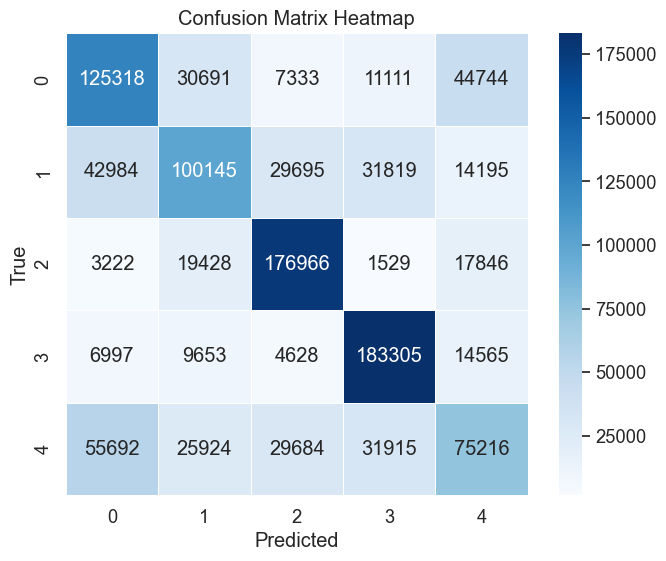

,none,comp1,comp2,comp3,comp4
accuracy,0.603825,0.603825,0.603825,0.603825,0.603825
precision,0.451569,0.535060,0.538875,0.712693,0.705891
recall,0.344347,0.571714,0.457622,0.808097,0.836444
F1,0.390736,0.552780,0.494935,0.757403,0.765642


In [75]:
print("Multi-class Logistic Regression")
logreg = LogisticRegression(multi_class = 'multinomial')

logreg = fit_classifier(logreg, X_train, y_train)
evaluate_classifier_2(logreg, X_test, y_test)

### Decision Tree

Decision Tree
Accuracy: 0.9962
ROC AUC Score: 0.9976


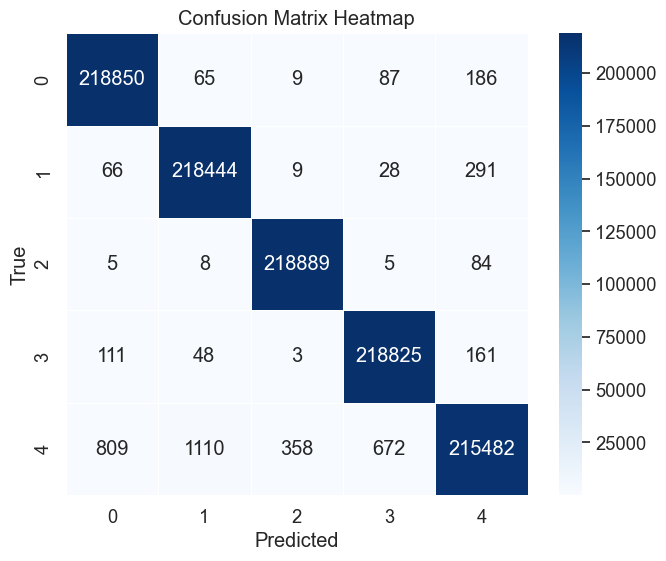

,none,comp1,comp2,comp3,comp4
accuracy,0.996241,0.996241,0.996241,0.996241,0.996241
precision,0.996661,0.995492,0.994396,0.998272,0.996394
recall,0.986499,0.998417,0.998200,0.999534,0.998526
F1,0.991554,0.996952,0.996294,0.998902,0.997459


In [76]:
print("Decision Tree")
dt_clf = DecisionTreeClassifier(random_state = 5)

dt_clf = fit_classifier(dt_clf, X_train, y_train)
evaluate_classifier_2(dt_clf, X_test, y_test)

### Bagging

Bagging of Decesion Trees
Accuracy: 0.9974
ROC AUC Score: 0.9998


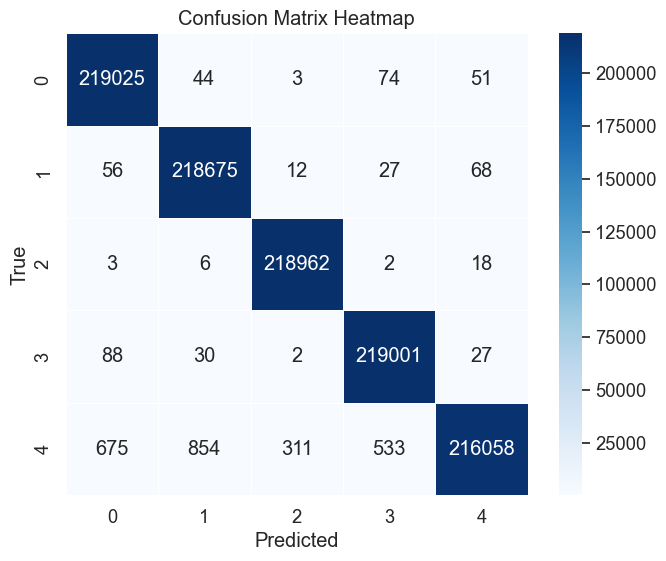

,none,comp1,comp2,comp3,comp4
accuracy,0.997365,0.997365,0.997365,0.997365,0.997365
precision,0.999242,0.996261,0.995747,0.998504,0.997104
recall,0.989136,0.999215,0.999255,0.999868,0.999329
F1,0.994163,0.997736,0.997498,0.999185,0.998216


In [77]:
print("Bagging of Decesion Trees")
bag_clf = BaggingClassifier(dt_clf, n_estimators=25, random_state=14)

bag_clf = fit_classifier(bag_clf, X_train, y_train)
evaluate_classifier_2(bag_clf, X_test, y_test)

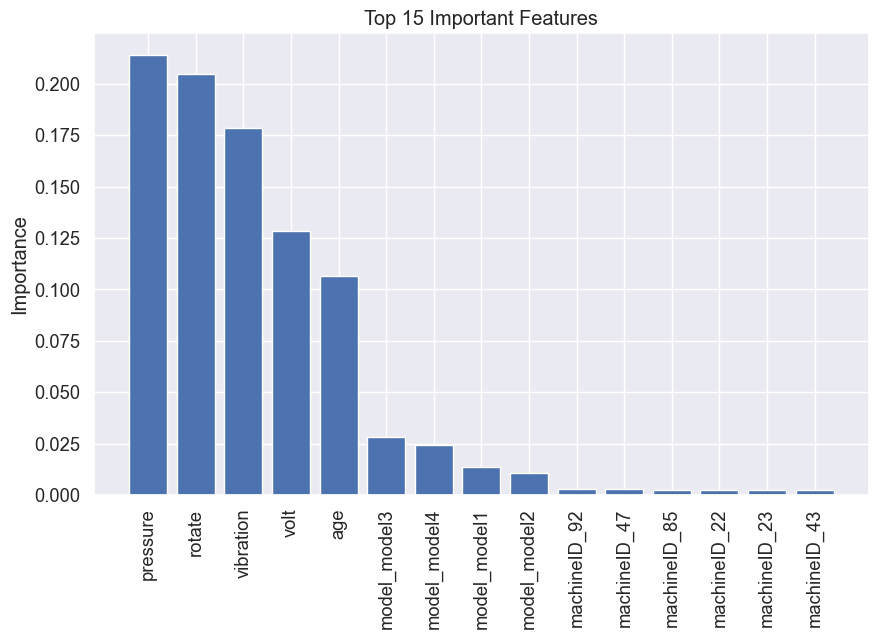

In [78]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# Assuming dt_clf has a 'feature_importances_' attribute
labels, importances = zip(*sorted(zip(X_test.columns, dt_clf.feature_importances_), reverse=True, key=lambda x: x[1]))

# Selecting the top 15 features
labels = labels[:15]
importances = importances[:15]

plt.bar(range(len(importances)), importances)
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.ylabel('Importance')
plt.title('Top 15 Important Features')
plt.show()

### Gradient Boosting Classifier

Gradient Boosting Classifier
Accuracy: 0.8167
ROC AUC Score: 0.9593


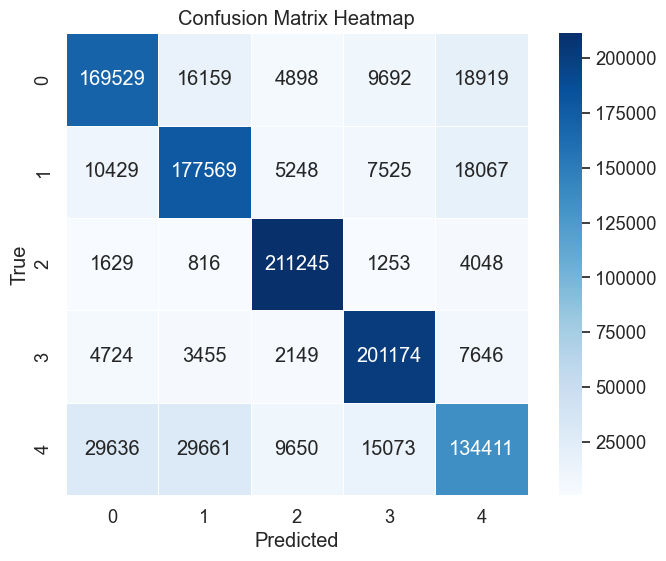

,none,comp1,comp2,comp3,comp4
accuracy,0.816667,0.816667,0.816667,0.816667,0.816667
precision,0.734121,0.785049,0.779975,0.905892,0.857092
recall,0.615348,0.773409,0.811418,0.964629,0.917982
F1,0.669508,0.779186,0.795385,0.934338,0.886493


In [79]:
print("Gradient Boosting Classifier")
gb_clf = GradientBoostingClassifier(random_state=5)

gb_clf = fit_classifier(gb_clf, X_train, y_train)
evaluate_classifier_2(gb_clf, X_test, y_test)

### XG Boost Classifier

Accuracy: 0.9736
ROC AUC Score: 0.9988


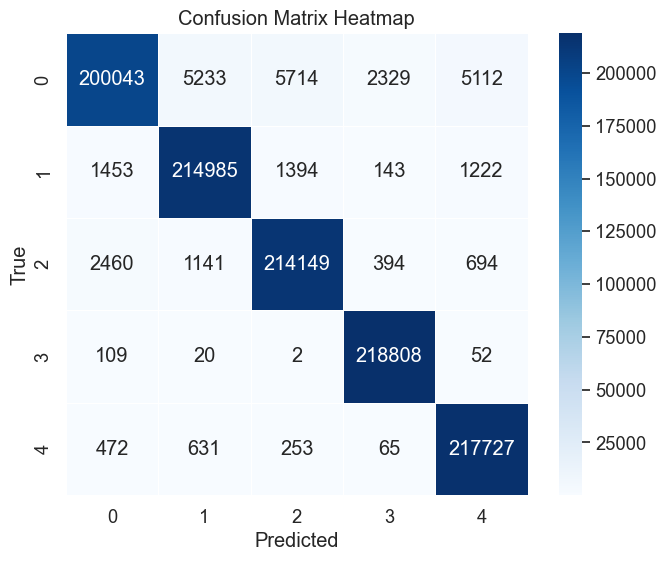

,none,comp1,comp2,comp3,comp4
accuracy,0.973604,0.973604,0.973604,0.973604,0.973604
precision,0.000000,0.000000,0.000000,0.000000,0.000000
recall,0.000000,0.000000,0.000000,0.000000,0.000000
F1,NaN,NaN,NaN,NaN,NaN


In [82]:
param_grid = {"n_estimators": [1, 10, 50, 100],
              "learning_rate": [0.01, 0.1, 0.5]}

y_train_xgb = y_train.replace(['none', 'comp1', 'comp2', 'comp3', 'comp4'], [0, 1, 2, 3, 4])
y_test_xgb = y_test.replace(['none', 'comp1', 'comp2', 'comp3', 'comp4'], [0, 1, 2, 3, 4])

# Initialize XGBoost classifier
xgb_clf = xgboost.XGBClassifier(learning_rate = 0.5, n_estimators = 100, random_state = 5)

# Getting the best params using GridSearchCV
#xgb_clf = grid_search_for_classifier(xgb_clf, param_grid, X_train, y_train_xgb)

# Fit the classifier using train data
xgb_clf = xgb_clf.fit(X_train, y_train_xgb)
# Get the performance on test data
evaluate_classifier_2(xgb_clf, X_test, y_test_xgb)

### Adaboost Classifier

Accuracy: 0.7074
ROC AUC Score: 0.8789


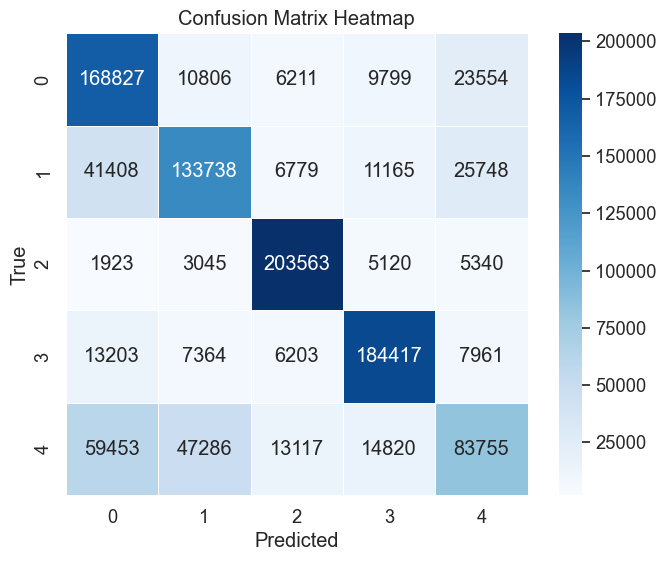

In [83]:
param_grid = {"n_estimators": [1, 10, 50, 100],
              "learning_rate": [0.01, 0.1, 0.5]}

# Initialize AdaBoost classifier
ab_clf = AdaBoostClassifier(learning_rate = 0.5, n_estimators = 50, random_state = 5)

# Getting the best params using GridSearchCV
#ab_clf = grid_search_for_classifier(ab_clf, param_grid, X_train, y_train)

# Fit the classifier using train data
ab_clf = fit_classifier(ab_clf, X_train, y_train)
# Get the performance on test data
evaluate_classifier(ab_clf, X_test, y_test)

# Failure prediction for Jan 1, 2016 to Jan 5, 2016

As Bagging Classfier is the best classifier among the different classifiers, we will use bagging classifier to predict whether there is going to be any failure in the next five days using the forecast data of telemetry readings, forecasted using time-series ARIMA models.

In [84]:
# Reading the forecast_data 
test_data = pd.read_csv('forecast_data.csv')
test_data = test_data.drop('datetime', axis=1)
test_data = test_data.drop(test_data.columns[0], axis=1)

test_data = pd.get_dummies(test_data, columns = ['machineID'])
for i in range(51,101):
    test_data['machineID_'+str(i)] = 0

test_data = test_data.drop('errorID', axis=1)
test_data = pd.get_dummies(test_data, columns = ['model'])
for i in range(1,6):
    test_data['errorID_error'+str(i)] = 0
test_data['errorID_none'] = 1

test_data.head()

,volt,rotate,pressure,vibration,age,machineID_1,machineID_2,machineID_3,machineID_4,machineID_5,...,model_model1,model_model2,model_model3,model_model4,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5,errorID_none
0,170.882407,442.098538,98.108723,40.515969,18,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,170.879874,441.104875,98.256143,40.438845,18,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,170.877450,441.328949,98.292459,40.512072,18,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,170.875132,441.543416,98.406228,40.453974,18,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,170.872914,441.748690,98.457813,40.510267,18,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [85]:
predictions = bag_clf.predict(test_data)
predictions

array(['none', 'none', 'none', ..., 'none', 'none', 'none'], dtype=object)

In [86]:
sum(predictions!='none')

0

This shows that there is going to be no failure for the next 5 days. However, predicting far into the future like 10 or 15 days will not yield good results as ARIMA models tend to forecast constant values for future periods, if the number of periods are more. 